In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

%config Completer.use_jedi = False

/kaggle/input/imdb-review-dataset/imdb_master.csv
/kaggle/input/200000-jeopardy-questions/JEOPARDY_CSV.csv


In [ ]:
!wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip
!unzip ./complaints.csv.zip


In [ ]:
import torch
import transformers
#!pip install Tez
#import tez
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, texts, targets, max_len = 64):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
                        "bert-base-uncased", do_lower_case = True
        )
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
                text,
                None,
                add_special_tokens = True,
                max_length = self.max_len,
                padding = "max_length",
                truncation = True
        )
        resp = {
            "ids" : torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask" : torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids" : torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets" : torch.tensor(self.targets["idx"], dtype = torch.float)
        }
        return resp
    
    
class TextModel(tez.Model):
    def __init__(self, num_classes, num_train_steps):
        super().__init__()
        self.bert = transformers.BertModel.from_pretrained(
                    "bert-base-uncased", return_dict = False
        )
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.optim_ = self.fetch_optimizer()
        
    def fetch_optimizer(self):
        opt = AdamW(self.parameters(), lr = 1e-4)
        
    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            AdamW(self.parameters(), lr = 1e-4), num_warmup_steps = 0,num_training_steps = self.num_train_steps
        )
        return sch
    
    
    def loss(self, outputs, targets):
        return nn.BCEWithLogitsLoss()(outputs, targets.view(-1,1))
    
    def monitor_metrics(self, outputs, targets):
        outputs = torch.sigmoid(outputs).cpu().detach().numpy() >= 0.5
        targets = targets.cpu().detach().numpy()
        return {
            "accuracy" : metrics.accruacy_score(targets, outputs)
        }
    
    def forward(self, ids, mark, token_type_ids, targets = None):
        _, x = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids)
        x = self.bert_drop(x)
        x = self.out(x)
        if(targets is not None):
            loss = self.loss(outputs , targets)
            metrics = self.monitor_metrics(x , targets)
            return x, loss, met
        return x, 0, {}
    

    def train_model(out1,out2):
        
        
        train_dataset = BERTDataset(out1.Title.values, out1.label.values)
        valid_dataset = BERTDataset(out2.Title.values, out2.label.values)
        
        n_train_steps = int(len(out1) / 32 * 10)
        
        model = TextModel(num_classes = 1, num_train_steps = n_train_steps, )
        
        ess = tez.callbacks.EarlyStopping(monitor = "valid_loss", patience = 3, model_path = "model.bin")
    
        model.fit(
                train_dataset,
                valid_dataset = valid_dataset,
                device = "cuda",
                epochs = 10,
                train_bs = 32,
                callbacks = [ess]
        )
    
    

    
    

In [ ]:
#!wget https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/title_conference.csv
!wget https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/title_conference.csv

In [2]:
df = pd.read_csv('../input/200000-jeopardy-questions/JEOPARDY_CSV.csv').fillna("none")
#df['Conference'].value_counts()
# possible_label = df[" Value"].unique()
# label_dict = {}
# for index, possible_label in enumerate(possible_label):
#     label_dict[possible_label] = index

# df['label'] = df[" Value"].replace(label_dict)
# #df.head()

In [3]:
df.head
df.isnull().sum()

Show Number    0
 Air Date      0
 Round         0
 Category      0
 Value         0
 Question      0
 Answer        0
dtype: int64

<AxesSubplot:xlabel=' Round', ylabel='count'>

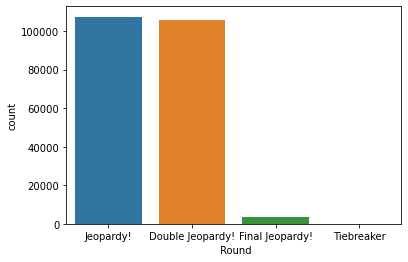

In [4]:
import seaborn as sns
sns.countplot(x=' Round',data=df)

In [5]:
df.drop(df[df[' Value'] == 'None'].index,inplace=True)

In [6]:
df['ValueNum'] = df[' Value'].apply(
    lambda value: int(value.replace('$', '').replace(',','')))

In [7]:
df['ValueNum'].unique()
df['ValueNum'].nunique()
def binning(value):
    if value < 1000:
        return np.round(value, -2)
    elif value < 10000:
        return np.round(value, -3)
    else:
        return np.round(value, -4)

df['ValueBins'] = df['ValueNum'].apply(binning)

In [8]:
import re
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
df['with_out_tags']=df[' Question'].apply(lambda cw : remove_tags(cw))

In [9]:
new_df = df[["with_out_tags","ValueBins"]].copy()

In [10]:
new_df['ValueBins'] = new_df['ValueBins'].astype('category')
# Assigning numerical values and storing in another column
new_df['labels'] = new_df['ValueBins'].cat.codes

In [11]:
new_df.labels.unique()

array([ 2,  4,  6,  8, 11, 10, 12, 14,  1,  3,  5, 13, 16,  7, 17, 15, 19,
        9, 18,  0, 20], dtype=int8)

In [12]:
final_df = new_df[["with_out_tags","labels"]].copy()
final_df

,with_out_tags,labels
0,"For the last 8 years of his life, Galileo was ...",2
1,No. 2: 1912 Olympian; football star at Carlisl...,2
2,The city of Yuma in this state has a record av...,2
3,"In 1963, live on ""The Art Linkletter Show"", th...",2
4,"Signer of the Dec. of Indep., framer of the Co...",2
...,...,...
216924,In 2006 the cast of this long-running hit emba...,11
216925,This Puccini opera turns on the solution to 3 ...,11
216926,In North America this term is properly applied...,11
216927,"In Penny Lane, where this ""Hellraiser"" grew up...",11


In [ ]:
new_Df['ValueBins'].value_counts()
possible_label = new_Df["ValueBins"].unique()
label_dict = {}
for index, possible_label in enumerate(possible_label):
    label_dict[possible_label] = index

new_Df['label'] = new_Df["ValueBins"].replace(label_dict)
new_Df.head()

In [ ]:
new_Df["label"].unique()
final_df = new_Df[["with_out_tags", "label"]]

In [ ]:
df.columns

In [ ]:
from sklearn.model_selection import KFold
#new_Df = df[['with_out_tags','ValueBins']]
#added some parameters
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
result = next(kf.split(final_df), None)




train = final_df.iloc[result[0]]
test =  final_df.iloc[result[1]]

In [ ]:
train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True) 


In [13]:
fin_df = final_df.sample(n = 50000)

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fin_df, test_size=0.2)

In [15]:
len(train)

40000

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_df.with_out_tags.values, final_df.labels.values, test_size=0.33,random_state=1)

In [ ]:
train, test = train_test_split(final_df, test_size=0.2, random_state=2019)

In [17]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


model_type = "Out"
model_name = "roberta"

train.columns = ["text", "labels"]
train_args = {
    'output_dir': f'{model_type}-{model_name}-outputs',

    'max_seq_length': 128,
    'num_train_epochs': 5,
    'train_batch_size': 16,
    'eval_batch_size': 32,
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'save_steps': -1,

    'wandb_project': 'Wysa',
    'wandb_kwargs': {'name': f'{model_type}-{model_name}'},
    'evaluate_during_training': True,
    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,
    'no_save' : True,

    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,
}




test.columns = ["text", "labels"]


# Optional model configuration
#model_args = ClassificationArgs(num_train_epochs=8)

# Create a ClassificationModel
model = ClassificationModel(
'roberta', 'roberta-base',
    num_labels=20,
    #args=model_args,
    args=train_args
) 

#model = ClassificationModel(model_type, model_name, num_labels=4, args=train_args)
# Train the model
model.train_model(train,eval_df=test)

# Evaluate the model
#result, model_outputs, wrong_predictions = model.eval_model(test)

# Make predictions with the model
#predictions, raw_outputs = model.predict(["Sam was a Wizard"])


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Running Epoch 0 of 5:   0%|          | 0/2500 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running Epoch 1 of 5:   0%|          | 0/2500 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/2500 [00:00<?, ?it/s]

(6000,
 {'global_step': [1000, 2000, 2500, 3000, 4000, 5000, 5000, 6000],
  'mcc': [0.005503259743957464, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'train_loss': [1.9665800333023071,
   2.2189440727233887,
   2.1500139236450195,
   2.266141414642334,
   2.181302547454834,
   2.6613011360168457,
   2.6613011360168457,
   2.086963176727295],
  'eval_loss': [2.1768621050130825,
   2.1539169866056107,
   2.135093469208422,
   2.1392436766395933,
   2.1460866806225276,
   2.144215387277329,
   2.144215387277329,
   2.1405205997034384]})

In [ ]:
!ls

In [ ]:
du - h ./final-roberta-outputs

In [ ]:
du -h final-roberta-outputs/

In [ ]:
ls -ltr

In [ ]:
model_best = ClassificationModel('roberta', 'outputs/best_model/', num_labels=5)

In [ ]:
ls

In [19]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
#result, model_outputs, wrong_predictions = model.eval_model(eval_df, f1=f1_multiclass, acc=accuracy_score)

result, model_outputs, wrong_predictions = model.eval_model(test, f1=f1_multiclass, acc=accuracy_score)

Running Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Training loss,2.08696
lr,3e-05
global_step,6000
_runtime,1980
_timestamp,1616007956
_step,127
mcc,0.0
train_loss,2.08696
eval_loss,2.14052


Training loss,█▃▂▃▂▆▁▄▂▂▃▄▃▃▂▂▃▄▂▅▅▂▃▂▃▃▃▃▂▁▄▃▄▃▄▃▃▄▃▂
lr,▁▃▄▆▇██████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
mcc,█▁▁▁▁▁▁▁
train_loss,▁▄▃▄▃██▂
eval_loss,█▄▁▂▃▃▃▂


wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
result

{'mcc': 0.0, 'f1': 0.1426, 'acc': 0.1426, 'eval_loss': 2.1405205997034384}

In [16]:
!pip install simpletransformers

     |████████████████████████████████| 206 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 7.5 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 4.6 MB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 29.6 MB/s eta 0:00:01


  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16170 sha256=b279f307262b9019bb221c9d16e3a0ea2211f6d0816a37f8934fb9d216f33b31
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.1.1
    Uninstalling ipykernel-5.1.1:
      Successfully uninstalled ipykernel-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.


In [ ]:
!wget https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [37]:
bow = CountVectorizer(stop_words='english', max_features=2000)
bow.fit(train['text'])

CountVectorizer(max_features=2000, stop_words='english')

In [38]:
X_train = bow.transform(train["text"])
X_test = bow.transform(test["text"])

y_train = train.labels
y_test = test.labels

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40000, 2000)
Shape of X_test: (10000, 2000)
Shape of y_train: (40000,)
Shape of y_test: (10000,)


In [40]:
lr = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=200)
lr.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(max_iter=200, multi_class='multinomial', solver='saga')

In [44]:
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.08      0.01      0.02       429
           2       0.16      0.16      0.16      1403
           3       0.06      0.01      0.02       409
           4       0.20      0.40      0.27      1986
           5       0.11      0.02      0.03       472
           6       0.11      0.05      0.07       993
           7       0.00      0.00      0.00         7
           8       0.14      0.13      0.13      1426
           9       0.00      0.00      0.00         3
          10       0.18      0.20      0.19      1561
          11       0.16      0.11      0.13      1202
          12       0.00      0.00      0.00        38
          13       0.00      0.00      0.00        38
          14       0.00      0.00      0.00        22
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         2
          17       0.00    

In [ ]:
print("DONE")